In [1]:
# Загрузка библиотек
!pip install pandas
!pip install matplotlib
!pip install scikit-learn
!pip install seaborn
!pip install numpy

# Импорт необходимых библиотек
from pandas import read_csv
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
#Multinomial Naive Bayes
from sklearn.naive_bayes import MultinomialNB
#Bernoulli Naive Bayes
from sklearn.naive_bayes import BernoulliNB
#Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Метрики оценки модели
# accuracy - точность, измеряет долю правильных предсказаний модели среди всех предсказаний
# precision - точность, измеряет долю истинно положительных предсказаний среди всех положительных предсказаний
# recall - полнота измеряет долю истинно положительных предсказаний среди всех реальных положительных случаев
# f1 - гармоническое среднее между точностью и полнотой.

In [2]:
# Загрузка датасета

url = "data\spam_or_not_spam.csv"

data = read_csv(url)

data.head()

,email,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which ...,0


# Анализ данных

In [3]:
#count (количество): Количество непустых значений в столбце.
#mean (среднее): Среднее значение.
#std (стандартное отклонение): Стандартное отклонение, которое измеряет разброс значений от среднего значения. Оно показывает, насколько значения в столбце 
# варьируются.
#min (минимум): Минимальное значение в столбце.
#25% (первый квартиль): Значение, ниже которого попадает 25% данных (нижний квартиль).
#50% (медиана): Медианное значение, которое разделяет данные на две равные половины.
#75% (третий квартиль): Значение, ниже которого попадает 75% данных (верхний квартиль).
#max (максимум): Максимальное значение в столбце.

In [4]:
data.describe()

,label
count,3000.000000
mean,0.166667
std,0.372740
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   email   2999 non-null   object
 1   label   3000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 47.0+ KB


In [6]:
#Удаляем пустые строки
df = data.dropna() 

#Удаляем повторяющиеся строки
idx = df.loc[df.duplicated(subset=['email'], keep=False)].index
data1 = df.drop(idx)

data1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2793 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   email   2793 non-null   object
 1   label   2793 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 65.5+ KB


In [7]:
# Находим индекс середины таблицы
middle_index = len(data1) - 380

# Указываем количество строк для вывода
num_rows = 12

text = data1.iloc[middle_index - num_rows // 2 : middle_index + num_rows // 2]

# Выводим строки из середины таблицы с указанным периодом
print(text)

                                                  email  label
2493  tim chapman writes URL wednesday NUMBER decemb...      0
2494   i had the same problem when installing win on...      0
2495  man killed trying to surf on tube train ananov...      0
2496  hi gianni a very good resource for this is URL...      0
2497  gianni ponzi wrote i have a prob when trying t...      0
2498  neale pickett neale woozle org writes skip mon...      0
2499   hi i think you need to give us a little more ...      0
2500   save up to NUMBER on life insurance why spend...      1
2503   adult club offers free membership instant acc...      1
2504  i thought you might like these NUMBER slim dow...      1
2505  a powerhouse gifting program you don t want to...      1
2506  help wanted we are a NUMBER year old fortune N...      1


In [8]:
# Значение, которое мы ищем
target_value = 1

# Считаем количество строк, где значение в столбце 'B' равно target_value
count = (data1['label'] == target_value).sum()

print("Количество строк со значением '{}' в столбце 'B': {}".format(target_value, count))

Количество строк со значением '1' в столбце 'B': 379


In [9]:
#Обработка текста
vectorizer = TfidfVectorizer(stop_words='english', lowercase=True)
X = vectorizer.fit_transform(data1['email'])
y = data1['label']

In [10]:
# Получение словаря слов
feature_names = vectorizer.get_feature_names_out()

# Преобразование разреженной матрицы в плотный формат
dense_X = X.toarray()

# Создание DataFrame с тремя колонками: Номер письма, Номер слова, Значение TF-IDF
rows = []
for i in range(dense_X.shape[0]):
    for j in range(dense_X.shape[1]):
        if dense_X[i, j] > 0:  # Сохраняем только ненулевые значения
            rows.append({"Номер письма": i, "Номер слова": j, "Значение TF-IDF": dense_X[i, j], "Слово": feature_names[j]})

results_dfX = pd.DataFrame(rows)

# Добавление колонки 'Номер письма и слова'
results_dfX['Номера письма и номер слова'] = results_dfX.apply(lambda row: f"{row['Номер письма']}_{row['Номер слова']}", axis=1)

# Переупорядочение колонок
results_dfX = results_dfX[['Номера письма и номер слова', 'Значение TF-IDF', 'Слово']]


# Выбор строк по индексу
selected_rows_by_index = results_dfX.iloc[[2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 2504, 2505, 2506]]
print(selected_rows_by_index)


     Номера письма и номер слова  Значение TF-IDF       Слово
2495                    29_21363         0.042615          pc
2496                    29_21415         0.069072       peats
2497                    29_21757         0.052764  physically
2498                    29_21770         0.040568        pick
2499                    29_21962         0.075698        play
2500                    29_22069         0.052186     pnumber
2501                    29_23724         0.030648        read
2502                    29_23733         0.037359     reading
2503                    29_23834         0.036630    recently
2504                    29_23943         0.039644      redhat
2505                    29_24430         0.065674       reran
2506                    29_25169         0.091562     running


In [27]:
# Преобразование разреженной матрицы в плотную
X_dense = X.todense()

# Определение количества строк для вывода
n_rows_to_show = 5

# Определение индексов для выборки строк из середины
start_index = (X_dense.shape[0] - n_rows_to_show) // 2
end_index = start_index + n_rows_to_show

# Вывод выбранных строк
print(X_dense[start_index:end_index, :])


[[0.         0.         0.13910118 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [12]:
#Выборка на тестовые и обучающие  части
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train_80, X_test_80, y_train_80, y_test_80 = train_test_split(X, y, test_size=0.8)
X_train_50, X_test_50, y_train_50, y_test_50 = train_test_split(X, y, test_size=0.5)

# Создание модели с помощью Дерева принятия решений

In [13]:
# Создание модели с выбранным алгоритмом
model = DecisionTreeClassifier()

# Обучение модели
model.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = model.predict(X_test)

# Оценка производительности модели с помощью выбранных метрик
accuracy = accuracy_score(y_test, y_pred)

# Создание модели логистической регрессии

In [14]:
# Создание модели логистической регрессии
logistic_model = LogisticRegression()

# Обучение модели логистической регрессии на обучающих данных
logistic_model.fit(X_train, y_train)

# Предсказание на тестовых данных
y_pred_logistic = logistic_model.predict(X_test)

# Оценка производительности модели логистической регрессии
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)

# Метод SVM

In [15]:
# Создание модели SVM
svm_model = SVC(kernel='linear')  # Линейное ядро

# Обучение модели SVM на обучающих данных
svm_model.fit(X_train, y_train)

# Предсказание на тестовых данных
y_pred_svm = svm_model.predict(X_test)

# Оценка производительности модели SVM
accuracy_svm = accuracy_score(y_test, y_pred_svm)

# Naive Bayes

In [16]:
# 20% на тестирование
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

naive_bayes_model_gaussian = GaussianNB()

naive_bayes_model_gaussian.fit(X_train_dense, y_train)

y_pred_naive_bayes_gaussian = naive_bayes_model_gaussian.predict(X_test_dense)

accuracy_gaussian = accuracy_score(y_test, y_pred_naive_bayes_gaussian)
precision_gaussian = precision_score(y_test, y_pred_naive_bayes_gaussian)
recall_gaussian = recall_score(y_test, y_pred_naive_bayes_gaussian)
f1_gaussian = f1_score(y_test, y_pred_naive_bayes_gaussian)

# 50% на тестирование
X_train_dense_50 = X_train_50.toarray()
X_test_dense_50 = X_test_50.toarray()

naive_bayes_model_gaussian.fit(X_train_dense_50, y_train_50)

y_pred_naive_bayes_gaussian_50 = naive_bayes_model_gaussian.predict(X_test_dense_50)

accuracy_gaussian_50 = accuracy_score(y_test_50, y_pred_naive_bayes_gaussian_50)
precision_gaussian_50 = precision_score(y_test_50, y_pred_naive_bayes_gaussian_50)
recall_gaussian_50 = recall_score(y_test_50, y_pred_naive_bayes_gaussian_50)
f1_gaussian_50 = f1_score(y_test_50, y_pred_naive_bayes_gaussian_50)

# 80% на тестирование
X_train_dense_80 = X_train_80.toarray()
X_test_dense_80 = X_test_80.toarray()

naive_bayes_model_gaussian.fit(X_train_dense_80, y_train_80)

y_pred_naive_bayes_gaussian_80 = naive_bayes_model_gaussian.predict(X_test_dense_80)

accuracy_gaussian_80 = accuracy_score(y_test_80, y_pred_naive_bayes_gaussian_80)
precision_gaussian_80 = precision_score(y_test_80, y_pred_naive_bayes_gaussian_80)
recall_gaussian_80 = recall_score(y_test_80, y_pred_naive_bayes_gaussian_80)
f1_gaussian_80 = f1_score(y_test_80, y_pred_naive_bayes_gaussian_80)

# Создание модели Multinomial Naive Bayes 
naive_bayes_model_multinomial = MultinomialNB()

naive_bayes_model_multinomial.fit(X_train_dense, y_train)

y_pred_naive_bayes_multinomial = naive_bayes_model_multinomial.predict(X_test_dense)

accuracy_multinomial = accuracy_score(y_test, y_pred_naive_bayes_multinomial)
precision_multinomial = precision_score(y_test, y_pred_naive_bayes_multinomial)
recall_multinomial = recall_score(y_test, y_pred_naive_bayes_multinomial)
f1_multinomial = f1_score(y_test, y_pred_naive_bayes_multinomial)

# Создание модели Multinomial Naive Bayes с настройкой параметра сглаживания alpha
naive_bayes_model_multinomial_alpha = MultinomialNB( alpha=0.1 )

naive_bayes_model_multinomial_alpha.fit(X_train_dense, y_train)

y_pred_naive_bayes_multinomial_alpha = naive_bayes_model_multinomial_alpha.predict(X_test_dense)

accuracy_multinomial_alpha = accuracy_score(y_test, y_pred_naive_bayes_multinomial_alpha)
precision_multinomial_alpha = precision_score(y_test, y_pred_naive_bayes_multinomial_alpha)
recall_multinomial_alpha = recall_score(y_test, y_pred_naive_bayes_multinomial_alpha)
f1_multinomial_alpha = f1_score(y_test, y_pred_naive_bayes_multinomial_alpha)

# Создание модели Бернолли наивного байесовского классификатора
naive_bayes_model_bernoulli = BernoulliNB()

naive_bayes_model_bernoulli.fit(X_train_dense, y_train)

y_pred_naive_bayes_bernoulli = naive_bayes_model_bernoulli.predict(X_test_dense)

accuracy_bernoulli = accuracy_score(y_test, y_pred_naive_bayes_bernoulli)
precision_bernoulli = precision_score(y_test, y_pred_naive_bayes_bernoulli)
recall_bernoulli = recall_score(y_test, y_pred_naive_bayes_bernoulli)
f1_bernoulli = f1_score(y_test, y_pred_naive_bayes_bernoulli)


# Вычисление матрицы ошибок Гауссовский
cm_naive_bayes = confusion_matrix(y_pred_naive_bayes_gaussian, y_test)

FP_naive_bayes = cm_naive_bayes[0, 1]
TP_naive_bayes = cm_naive_bayes[1, 1]
TN_naive_bayes = cm_naive_bayes[0, 0]
FN_naive_bayes = cm_naive_bayes[1, 0]

# Вычисление precision
precision1_naive_bayes = TP_naive_bayes / (TP_naive_bayes + FP_naive_bayes)
precision0_naive_bayes = TN_naive_bayes / (TN_naive_bayes + FN_naive_bayes)

# Вычисление recall
recall1_naive_bayes = TP_naive_bayes / (TP_naive_bayes + FN_naive_bayes)
recall0_naive_bayes = TN_naive_bayes / (TN_naive_bayes + FP_naive_bayes)

# Вычисление f1
f11_naive_bayes = 2 * precision1_naive_bayes * recall1_naive_bayes / (precision1_naive_bayes + recall1_naive_bayes)
f10_naive_bayes =  2 * precision0_naive_bayes * recall0_naive_bayes / (precision0_naive_bayes + recall0_naive_bayes)

# Вычисление матрицы ошибок Мультиноминальный
cm_multinomial = confusion_matrix(y_pred_naive_bayes_multinomial, y_test)

FP_multinomial = cm_multinomial[0, 1]
TP_multinomial = cm_multinomial[1, 1]
TN_multinomial = cm_multinomial[0, 0]
FN_multinomial = cm_multinomial[1, 0]

# Вычисление precision
precision1_multinomial = TP_multinomial / (TP_multinomial + FP_multinomial)
precision0_multinomial = TN_multinomial / (TN_multinomial + FN_multinomial)

# Вычисление recall
recall1_multinomial = TP_multinomial / (TP_multinomial + FN_multinomial)
recall0_multinomial = TN_multinomial / (TN_multinomial + FP_multinomial)

# Вычисление f1
f11_multinomial = 2 * precision1_multinomial * recall1_multinomial / (precision1_multinomial + recall1_multinomial)
f10_multinomial =  2 * precision0_multinomial * recall0_multinomial / (precision0_multinomial + recall0_multinomial)

# Вычисление матрицы ошибок Мультиноминальный улучшенный
cm_alpha = confusion_matrix(y_pred_naive_bayes_multinomial_alpha, y_test)

FP_alpha = cm_alpha[0, 1]
TP_alpha = cm_alpha[1, 1]
TN_alpha = cm_alpha[0, 0]
FN_alpha = cm_alpha[1, 0]

# Вычисление precision
precision1_alpha = TP_alpha / (TP_alpha + FP_alpha)
precision0_alpha = TN_alpha / (TN_alpha + FN_alpha)

# Вычисление recall
recall1_alpha = TP_alpha / (TP_alpha + FN_alpha)
recall0_alpha = TN_alpha / (TN_alpha + FP_alpha)

# Вычисление f1
f11_alpha = 2 * precision1_alpha * recall1_alpha / (precision1_alpha + recall1_alpha)
f10_alpha =  2 * precision0_alpha * recall0_alpha / (precision0_alpha + recall0_alpha)

# Вычисление матрицы ошибок Бернулли
cm_bernoulli = confusion_matrix(y_pred_naive_bayes_bernoulli, y_test)

FP_bernoulli = cm_bernoulli[0, 1]
TP_bernoulli = cm_bernoulli[1, 1]
TN_bernoulli = cm_bernoulli[0, 0]
FN_bernoulli = cm_bernoulli[1, 0]

# Вычисление precision
precision1_bernoulli = TP_bernoulli / (TP_bernoulli + FP_bernoulli)
precision0_bernoulli = TN_bernoulli / (TN_bernoulli + FN_bernoulli)

# Вычисление recall
recall1_bernoulli = TP_bernoulli / (TP_bernoulli + FN_bernoulli)
recall0_bernoulli = TN_bernoulli / (TN_bernoulli + FP_bernoulli)

# Вычисление f1
f11_bernoulli = 2 * precision1_bernoulli * recall1_bernoulli / (precision1_bernoulli + recall1_bernoulli)
f10_bernoulli =  2 * precision0_bernoulli * recall0_bernoulli / (precision0_bernoulli + recall0_bernoulli)


cm_50 = confusion_matrix(y_pred_naive_bayes_gaussian_50, y_test_50)

FP_50 = cm_50[0, 1]
TP_50 = cm_50[1, 1]
TN_50 = cm_50[0, 0]
FN_50 = cm_50[1, 0]

# Вычисление precision
precision1_50 = TP_50 / (TP_50 + FP_50)
precision0_50 = TN_50 / (TN_50 + FN_50)

# Вычисление recall
recall1_50 = TP_50 / (TP_50 + FN_50)
recall0_50 = TN_50 / (TN_50 + FP_50)

# Вычисление f1
f11_50 = 2 * precision1_50 * recall1_50 / (precision1_50 + recall1_50)
f10_50 =  2 * precision0_50 * recall0_50 / (precision0_50 + recall0_50)

cm_80 = confusion_matrix(y_pred_naive_bayes_gaussian_80, y_test_80)

FP_80 = cm_80[0, 1]
TP_80 = cm_80[1, 1]
TN_80 = cm_80[0, 0]
FN_80 = cm_80[1, 0]

# Вычисление precision
precision1_80 = TP_80 / (TP_80 + FP_80)
precision0_80 = TN_80 / (TN_80 + FN_80)

# Вычисление recall
recall1_80 = TP_80 / (TP_80 + FN_80)
recall0_80 = TN_80 / (TN_80 + FP_80)

# Вычисление f1
f11_80 = 2 * precision1_80 * recall1_80 / (precision1_80 + recall1_80)
f10_80 =  2 * precision0_80 * recall0_80 / (precision0_80 + recall0_80)


In [17]:
results_df = pd.DataFrame(columns=['Метод', 'Accuracy', 'Precision_1', 'Precision_0', 'Recall_1', 'Recall_0', 'F1_1', 'F1_0'])

results_df.loc[0] = ['Multinomial', "{:.2f}".format(accuracy_multinomial), "{:.2f}".format(precision1_multinomial), "{:.2f}".format(precision0_multinomial), "{:.2f}".format(recall1_multinomial), "{:.2f}".format(recall0_multinomial), "{:.2f}".format(f11_multinomial), "{:.2f}".format(f10_multinomial)]
#results_df.loc[1] = ['Multinomial_alpha', "{:.2f}".format(accuracy_multinomial_alpha), "{:.2f}".format(precision1_alpha), "{:.2f}".format(precision0_alpha), "{:.2f}".format(recall1_alpha), "{:.2f}".format(recall0_alpha), "{:.2f}".format(f11_alpha), "{:.2f}".format(f10_alpha)]
results_df.loc[2] = ['Bernoulli', "{:.2f}".format(accuracy_bernoulli), "{:.2f}".format(precision1_bernoulli), "{:.2f}".format(precision0_bernoulli), "{:.2f}".format(recall1_bernoulli), "{:.2f}".format(recall0_bernoulli), "{:.2f}".format(f11_bernoulli), "{:.2f}".format(f10_bernoulli)]
results_df.loc[3] = ['Gaussian', "{:.2f}".format(accuracy_gaussian), "{:.2f}".format(precision1_naive_bayes), "{:.2f}".format(precision0_naive_bayes), "{:.2f}".format(recall1_naive_bayes), "{:.2f}".format(recall0_naive_bayes), "{:.2f}".format(f11_naive_bayes), "{:.2f}".format(f10_naive_bayes)]

# Выводим результаты
print(results_df)

print("")
print("17.04.2024 21:52")

         Метод Accuracy Precision_1 Precision_0 Recall_1 Recall_0  F1_1  F1_0
0  Multinomial     0.91        0.25        1.00     1.00     0.91  0.40  0.95
2    Bernoulli     0.89        0.29        0.98     0.65     0.91  0.40  0.94
3     Gaussian     0.92        0.60        0.97     0.73     0.95  0.66  0.96

17.04.2024 21:52


In [18]:
results_df = pd.DataFrame(columns=['Проценты на тестовую часть', 'Accuracy', 'Precision_1', 'Precision_0', 'Recall_1', 'Recall_0', 'F1_1', 'F1_0'])

results_df.loc[0] = ['20% на тестирование', "{:.2f}".format(accuracy_gaussian), "{:.2f}".format(precision1_naive_bayes), "{:.2f}".format(precision0_naive_bayes), "{:.2f}".format(recall1_naive_bayes), "{:.2f}".format(recall0_naive_bayes), "{:.2f}".format(f11_naive_bayes), "{:.2f}".format(f10_naive_bayes)]
results_df.loc[1] = ['50% на тестирование', "{:.2f}".format(accuracy_gaussian_50), "{:.2f}".format(precision1_50), "{:.2f}".format(precision0_50), "{:.2f}".format(recall1_50), "{:.2f}".format(recall0_50), "{:.2f}".format(f11_50), "{:.2f}".format(f10_50)]
results_df.loc[2] = ['80% на тестирование', "{:.2f}".format(accuracy_gaussian_80),"{:.2f}".format(precision1_80), "{:.2f}".format(precision0_80), "{:.2f}".format(recall1_80), "{:.2f}".format(recall0_80), "{:.2f}".format(f11_80), "{:.2f}".format(f10_80)]

# Выводим результаты
print(results_df)

print("")
print("17.04.2024 23:22")

  Проценты на тестовую часть Accuracy Precision_1 Precision_0 Recall_1  \
0        20% на тестирование     0.92        0.60        0.97     0.73   
1        50% на тестирование     0.94        0.62        0.99     0.92   
2        80% на тестирование     0.94        0.60        0.99     0.90   

  Recall_0  F1_1  F1_0  
0     0.95  0.66  0.96  
1     0.94  0.75  0.97  
2     0.94  0.72  0.96  

17.04.2024 23:22


In [19]:
# Вывод результатов
print("Метрики производительности 08.04.2024 20:08:")
print("Accuracy:", "{:.2f}".format(accuracy_gaussian))
print("Precision_1:", "{:.2f}".format(precision1_naive_bayes))
print("Precision_0:", "{:.2f}".format(precision0_naive_bayes))
print("Recall_1:", "{:.2f}".format(recall1_naive_bayes))
print("Recall_0:", "{:.2f}".format(recall0_naive_bayes))
print("F1_1:", "{:.2f}".format(f11_naive_bayes))
print("F1_0:", "{:.2f}".format(f10_naive_bayes))

Метрики производительности 08.04.2024 20:08:
Accuracy: 0.92
Precision_1: 0.60
Precision_0: 0.97
Recall_1: 0.73
Recall_0: 0.95
F1_1: 0.66
F1_0: 0.96


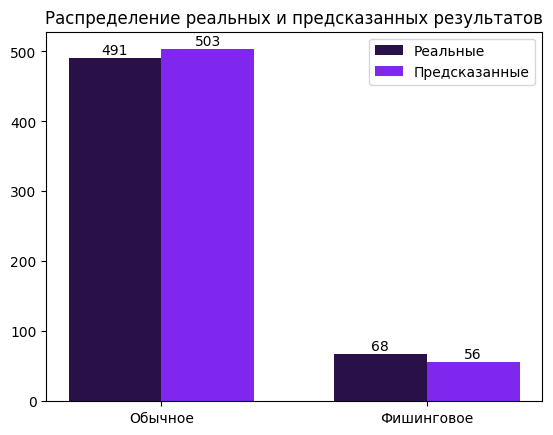

In [20]:
unique_labels_test, counts_test = np.unique(y_test, return_counts=True)
unique_labels_pred, counts_pred = np.unique(y_pred_naive_bayes_gaussian, return_counts=True)

name = ['1', '2']

# Создание подписей для классов
labels = ['Обычное', 'Фишинговое']

# Создание фигуры и осей
fig, ax = plt.subplots()

# Ширина столбцов
width = 0.35

# Создание столбцов для тестовых и предсказанных значений
bars1 = ax.bar(np.arange(len(counts_test)) - width/2, counts_test, width, label='Реальные', color='#291048')
bars2 = ax.bar(np.arange(len(counts_pred)) + width/2, counts_pred, width, label='Предсказанные', color='#7F26EF')

# Добавление значений к столбцам
for i, count in enumerate(counts_test):
    ax.text(i - width/2, count + 1, str(count), ha='center', va='bottom')

for i, count in enumerate(counts_pred):
    ax.text(i + width/2, count + 1, str(count), ha='center', va='bottom')

# Установка подписей и заголовка
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_title('Распределение реальных и предсказанных результатов')

# Добавление легенды
ax.legend()

# Отображение графика
plt.show()


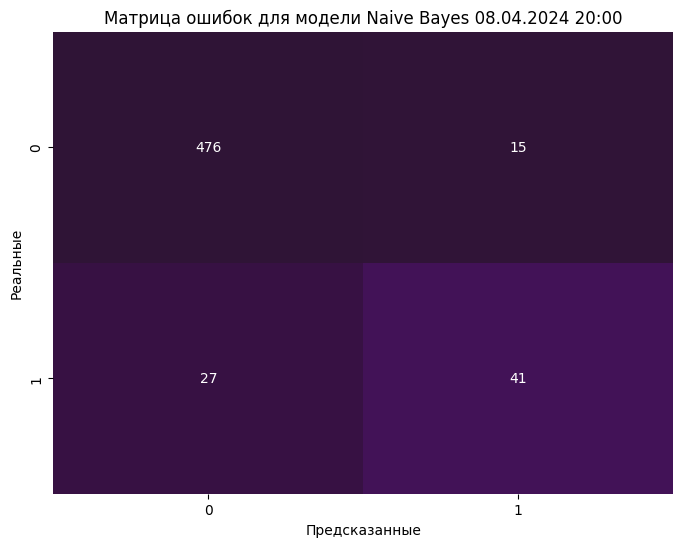

In [21]:
# Вычисление матрицы ошибок для модели Naive Bayes
conf_matrix_naive_bayes = confusion_matrix(y_test, y_pred_naive_bayes_gaussian)

# Создание тепловой карты для матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_naive_bayes, annot=True, cmap='twilight_shifted', fmt='g', cbar=False)

# Настройка названий осей и заголовка
plt.title('Матрица ошибок для модели Naive Bayes 08.04.2024 20:00')
plt.ylabel('Реальные')
plt.xlabel('Предсказанные')

# Показать график
plt.show()

# Сравнение Naive Bayes с другими методами

In [22]:

cm_logistic = confusion_matrix(y_pred_logistic, y_test)

FP_logistic = cm_logistic[0, 1]
TP_logistic = cm_logistic[1, 1]
TN_logistic = cm_logistic[0, 0]
FN_logistic = cm_logistic[1, 0]

# Вычисление precision
precision1_logistic = TP_logistic / (TP_logistic + FP_logistic)
precision0_logistic = TN_logistic / (TN_logistic + FN_logistic)

# Вычисление recall
recall1_logistic = TP_logistic / (TP_logistic + FN_logistic)
recall0_logistic = TN_logistic / (TN_logistic + FP_logistic)

# Вычисление f1
f11_logistic = 2 * precision1_logistic * recall1_logistic / (precision1_logistic + recall1_logistic)
f10_logistic =  2 * precision0_logistic * recall0_logistic / (precision0_logistic + recall0_logistic)

cm = confusion_matrix(y_pred, y_test)

FP = cm[0, 1]
TP = cm[1, 1]
TN = cm[0, 0]
FN = cm[1, 0]

# Вычисление precision
precision1 = TP / (TP + FP)
precision0 = TN / (TN + FN)

# Вычисление recall
recall1 = TP / (TP + FN)
recall0 = TN / (TN + FP)

# Вычисление f1
f11 = 2 * precision1 * recall1 / (precision1 + recall1)
f10 =  2 * precision0 * recall0 / (precision0 + recall0)

cm_svm = confusion_matrix(y_pred_svm, y_test)

FP_svm = cm_svm[0, 1]
TP_svm = cm_svm[1, 1]
TN_svm = cm_svm[0, 0]
FN_svm = cm_svm[1, 0]

# Вычисление precision
precision1_svm = TP_svm / (TP_svm + FP_svm)
precision0_svm = TN_svm / (TN_svm + FN_svm)

# Вычисление recall
recall1_svm = TP_svm / (TP_svm + FN_svm)
recall0_svm = TN_svm / (TN_svm + FP_svm)

# Вычисление f1
f11_svm = 2 * precision1_svm * recall1_svm / (precision1_svm + recall1_svm)
f10_svm =  2 * precision0_svm * recall0_svm / (precision0_svm + recall0_svm)

results_df = pd.DataFrame(columns=['Алгоритмы', 'Accuracy', 'Precision_1', 'Precision_0', 'Recall_1', 'Recall_0', 'F1_1', 'F1_0'])


results_df.loc[0] = ['NaiveBayes:', "{:.2f}".format(accuracy_gaussian), "{:.2f}".format(precision1_naive_bayes),"{:.2f}".format(precision0_naive_bayes), "{:.2f}".format(recall1_naive_bayes), "{:.2f}".format(recall0_naive_bayes), "{:.2f}".format(f11_naive_bayes), "{:.2f}".format(f10_naive_bayes)]
results_df.loc[1] = ['Logistic Regression:', "{:.2f}".format(accuracy_logistic), "{:.2f}".format(precision1_logistic),"{:.2f}".format(precision0_logistic), "{:.2f}".format(recall1_logistic), "{:.2f}".format(recall0_logistic), "{:.2f}".format(f11_logistic), "{:.2f}".format(f10_logistic)]
results_df.loc[2] = ['Decision Trees:', "{:.2f}".format(accuracy), "{:.2f}".format(precision1),"{:.2f}".format(precision0), "{:.2f}".format(recall1), "{:.2f}".format(recall0),  "{:.2f}".format(f11), "{:.2f}".format(f10)]
results_df.loc[3] = ['SVM:', "{:.2f}".format(accuracy_svm), "{:.2f}".format(precision1_svm),"{:.2f}".format(precision0_svm), "{:.2f}".format(recall1_svm), "{:.2f}".format(recall0_svm), "{:.2f}".format(f11_svm), "{:.2f}".format(f10_svm)]

# Выводим результаты
print(results_df)

print("20.05.2024 23:20")

              Алгоритмы Accuracy Precision_1 Precision_0 Recall_1 Recall_0  \
0           NaiveBayes:     0.92        0.60        0.97     0.73     0.95   
1  Logistic Regression:     0.95        0.59        1.00     1.00     0.95   
2       Decision Trees:     0.97        0.91        0.98     0.86     0.99   
3                  SVM:     0.98        0.88        1.00     0.98     0.98   

   F1_1  F1_0  
0  0.66  0.96  
1  0.74  0.97  
2  0.89  0.98  
3  0.93  0.99  
20.05.2024 23:20
